In [52]:
import random
from matplotlib import pyplot as plt

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import DataLoader

from dataset import MaskBaseDataset, BaseAugmentation

from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce

In [54]:
BATCH_SIZE = 128
NUM_HEADS = 4
HEIGHT = 128
WIDTH = 96
PATCH_SIZE = 32
EMBED_DIM = 4 * 4 * 3
RESIZE = [HEIGHT, WIDTH]
NUM_CLASSES = 18

In [55]:
train_data_path = "../input/data/train/images"
maskBaseDataset = MaskBaseDataset(data_dir=train_data_path)

In [56]:
transform_module = BaseAugmentation # default: BaseAugmentation
transform = transform_module(
    resize=RESIZE,
    mean=maskBaseDataset.mean,
    std=maskBaseDataset.std,
)
maskBaseDataset.set_transform(transform)

In [57]:
next(iter(maskBaseDataset))

(tensor([[[ 1.0467,  1.0633,  1.0633,  ...,  1.1460,  1.1626,  1.1626],
          [ 1.0633,  1.0798,  1.0633,  ...,  1.1460,  1.1295,  1.1295],
          [ 1.0633,  1.0633,  1.0467,  ...,  1.1129,  1.1295,  1.1295],
          ...,
          [ 0.5669,  0.5007,  0.6331,  ...,  0.9309,  0.9640,  0.9309],
          [ 0.5834,  0.5173,  0.6331,  ...,  0.9475,  0.9309,  0.8151],
          [ 0.5834,  0.5007,  0.5669,  ...,  0.9309,  0.9144,  0.6993]],
 
         [[ 1.0237,  1.0396,  1.0396,  ...,  1.1190,  1.1349,  1.1349],
          [ 1.0396,  1.0555,  1.0396,  ...,  1.1190,  1.1031,  1.1031],
          [ 1.0396,  1.0396,  1.0237,  ...,  1.0872,  1.1031,  1.1031],
          ...,
          [ 0.3093,  0.2775,  0.4363,  ...,  0.7380,  0.7697,  0.7380],
          [ 0.3410,  0.2934,  0.4363,  ...,  0.7538,  0.7380,  0.6268],
          [ 0.3410,  0.2775,  0.3887,  ...,  0.7380,  0.7221,  0.5157]],
 
         [[ 0.9861,  1.0020,  1.0020,  ...,  1.1933,  1.2092,  1.2092],
          [ 1.0020,  1.0179,

Index: 3374
Mask: NOT WEAR
Gender: FEMALE
Age: OLD
Image Size: (384, 512)


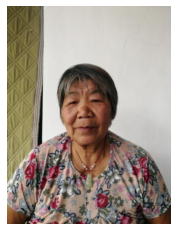

In [58]:
random_index = random.randrange(0, len(maskBaseDataset))
mask = maskBaseDataset.get_mask(random_index)
gender = maskBaseDataset.get_gender(random_index)
age = maskBaseDataset.get_age(random_index)
image = maskBaseDataset.get_image(random_index)

print(f'Index: {random_index}')
print(f'Mask: {mask}')
print(f'Gender: {gender}')
print(f'Age: {age}')
print(f'Image Size: {image.size}')

plt.axis('off')
plt.imshow(image)

In [59]:
random_index = random.randrange(0, len(maskBaseDataset))
print(f'Index: {random_index}')
print(f'Size: {maskBaseDataset[random_index][0].size()}')
maskBaseDataset[random_index]

Index: 9776
Size: torch.Size([3, 128, 96])


(tensor([[[ 0.6662,  0.6827,  0.6827,  ..., -0.4756, -0.5086, -0.5583],
          [ 0.6827,  0.6993,  0.7158,  ...,  0.0374,  0.0043, -0.0288],
          [ 0.6827,  0.7158,  0.7158,  ...,  0.3683,  0.3849,  0.3849],
          ...,
          [ 1.2453,  1.2619,  0.6827,  ..., -0.3432, -0.2935, -0.3597],
          [ 1.2784,  1.2619,  0.3683,  ..., -0.4756, -0.6907, -0.2770],
          [ 1.2949,  1.1791, -0.0122,  ..., -0.3928, -0.4425, -0.2770]],
 
         [[ 0.8332,  0.8491,  0.8491,  ..., -1.0085, -1.0561, -1.1038],
          [ 0.8491,  0.8650,  0.8808,  ..., -0.6275, -0.6751, -0.6910],
          [ 0.8491,  0.8808,  0.8808,  ..., -0.3893, -0.3893, -0.3893],
          ...,
          [ 1.6112,  1.5794,  0.9761,  ..., -0.0083,  0.0394, -0.0241],
          [ 1.5953,  1.5477,  0.6427,  ..., -0.1353, -0.3417,  0.0553],
          [ 1.5794,  1.4524,  0.2616,  ..., -0.0559, -0.1035,  0.0553]],
 
         [[ 0.7150,  0.7310,  0.7310,  ..., -1.4849, -1.5167, -1.5646],
          [ 0.7310,  0.7469,

In [60]:
train_dataset, val_dataset = maskBaseDataset.split_dataset()

In [61]:
print(f'Number of Train Dataset: {len(train_dataset)}')
print(f'Number of Validation Dataset: {len(val_dataset)}')

Number of Train Dataset: 15120
Number of Validation Dataset: 3780


In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
random_image = maskBaseDataset[random_index][0].unsqueeze(0)

In [64]:
class Image_Embedding(nn.Module):
    def __init__(self,
                 num_channel: int = 3,
                 width: int = WIDTH,
                 height: int = HEIGHT,
                 patch_size: int = PATCH_SIZE,
                 embedded_dim: int = EMBED_DIM,
                 verbose: bool = False):
        super().__init__()
        self.width = width
        self.height = height
        self.verbose = verbose

        self.rearrange = Rearrange('b c (num_w p1) (num_h p2) -> b (num_w num_h) (p1 p2 c) ', p1 = patch_size, p2 = patch_size)
        self.linear = nn.Linear(num_channel * patch_size * patch_size, embedded_dim)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embedded_dim))

        n_patches = self.width * self.height // (patch_size ** 2)
        self.positions = nn.Parameter(torch.randn(n_patches + 1, embedded_dim))

    def forward(self, x):
        batch, channel, width, height = x.shape

        if self.verbose:
            print(x.shape)

        x = self.rearrange(x)

        if self.verbose:
            print(x.shape)

        x = self.linear(x)

        if self.verbose:
            print(x.shape)

        c = repeat(self.cls_token, '() n d -> b n d', b=batch)
        x = torch.cat((c, x), dim=1)
        x = x + self.positions

        return x

embedded_image = Image_Embedding(3, WIDTH, HEIGHT, PATCH_SIZE, 6*6*3)(random_image)
embedded_image.shape

torch.Size([1, 13, 108])

In [65]:
class MHA(nn.Module):
    def __init__(self,
                 embedded_dim: int = EMBED_DIM ,
                 num_heads: int = NUM_HEADS,
                 dropout_ratio: float = 0.2,
                 verbose: bool = False):
        super(MHA, self). __init__()

        self.verbose = verbose
        self.embedded_dim = embedded_dim
        self.num_heads = num_heads
        self.scaling = (embedded_dim // num_heads) ** -0.5

        self.value = nn.Linear(embedded_dim, embedded_dim)
        self.key = nn.Linear(embedded_dim, embedded_dim)
        self.query = nn.Linear(embedded_dim, embedded_dim)
        self.drop = nn.Dropout(dropout_ratio)

        self.linear = nn.Linear(embedded_dim, embedded_dim)

    def forward(self, x: torch.Tensor):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        if self.verbose:
            print(f'Size of Q: {Q.size()}')
            print(f'Size of K: {K.size()}')
            print(f'Size of V: {V.size()}')

        Q = rearrange(Q, 'b q (h d) -> b h q d', h=self.num_heads)
        # K는 Q와 multiplication 해야 하므로 transpose를 취한 형태로 바꿔준다.
        K = rearrange(K, 'b k (h d) -> b h d k', h=self.num_heads)
        V = rearrange(V, 'b v (h d) -> b h v d', h=self.num_heads)

        if self.verbose:
            print(f'Size of Q: {Q.size()}')
            print(f'Size of K: {K.size()}')
            print(f'Size of V: {V.size()}')

        weight = torch.matmul(Q, K)
        weight = weight * self.scaling

        if self.verbose:
            print(f'Size of Weight: {weight.size()}')

        attention = torch.softmax(weight, dim=-1)
        attention = self.drop(attention)

        if self.verbose:
            print(f'Size of Attention: {attention.size()}')

        context = torch.matmul(attention, V)
        context = rearrange(context, 'b h q d -> b q (h d)')

        if self.verbose:
            print(f'Size of Context: {context.size()}')

        x = self.linear(context)
        return x, attention

feature, attention = MHA(6*6*3, 2, verbose=True)(embedded_image)
print(f'Size of Feature: {feature.shape}')
print(f'Size of Attention: {attention.shape}')


Size of Q: torch.Size([1, 13, 108])
Size of K: torch.Size([1, 13, 108])
Size of V: torch.Size([1, 13, 108])
Size of Q: torch.Size([1, 2, 13, 54])
Size of K: torch.Size([1, 2, 54, 13])
Size of V: torch.Size([1, 2, 13, 54])
Size of Weight: torch.Size([1, 2, 13, 13])
Size of Attention: torch.Size([1, 2, 13, 13])
Size of Context: torch.Size([1, 13, 108])
Size of Feature: torch.Size([1, 13, 108])
Size of Attention: torch.Size([1, 2, 13, 13])


In [66]:
class MLP_Block(nn.Module):
    def __init__(self,
                 embedded_dim: int = EMBED_DIM,
                 forward_dim: int = 4,
                 dropout_ratio:
                 float = 0.2, **kwargs):
        super().__init__()
        self.linear_1 = nn.Linear(embedded_dim, forward_dim * embedded_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.linear_2 = nn.Linear(forward_dim * embedded_dim, embedded_dim)

    def forward(self, x):
        x = self.linear_1(x)
        x = nn.functional.gelu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = nn.functional.gelu(x)
        x = self.dropout(x)
        return x

In [67]:
class Encoder_Block(nn.Sequential):
    def __init__(self,
                 embedded_dim: int = EMBED_DIM,
                 num_heads: int = NUM_HEADS,
                 forward_dim: int = 4,
                 dropout_ratio:float = 0.2):
        super().__init__()

        self.norm_1 = nn.LayerNorm(embedded_dim)
        self.mha = MHA(embedded_dim, num_heads, dropout_ratio)

        self.norm_2 = nn.LayerNorm(embedded_dim)
        self.mlp = MLP_Block(embedded_dim, forward_dim, dropout_ratio)

        self.residual_droupout = nn.Dropout(dropout_ratio)

    def forward(self, x):
        x_ = self.norm_1(x)
        x_, attention = self.mha(x_)
        x = x_ + self.residual_droupout(x)

        x_ = self.norm_2(x)
        x_ = self.mlp(x_)
        x = x_ + self.residual_droupout(x)

        return x, attention

feature, attention = Encoder_Block(6*6*3)(embedded_image)
print(f'Size of Feature: {feature.shape}')
print(f'Size of Attention: {attention.shape}')

Size of Feature: torch.Size([1, 13, 108])
Size of Attention: torch.Size([1, 4, 13, 13])


In [68]:
class Vision_Transformer(nn.Module):
    def __init__(self,
                 num_channel: int = 3,
                 width: int = WIDTH,
                 height: int = HEIGHT,
                 patch_size: int = PATCH_SIZE,
                 embedded_dim:int = EMBED_DIM,
                 num_encoder_layers:int = 3,
                 num_heads:int = NUM_HEADS,
                 forward_dim: int = 4,
                 dropout_ratio: float = 0.2,
                 num_classes:int = NUM_CLASSES):
        super().__init__()

        self.embed_image = Image_Embedding(num_channel, width, height, patch_size, embedded_dim)
        self.transformer_encoders = nn.ModuleList([
            Encoder_Block(embedded_dim, num_heads, forward_dim, dropout_ratio) for _ in range(num_encoder_layers)
        ])

        self.reduce_layer = Reduce('b n e -> b e', reduction='mean')
        self.normalization = nn.LayerNorm(embedded_dim)
        self.classification_head = nn.Linear(embedded_dim, num_classes)

    def forward(self, x):
        x = self.embed_image(x)

        attentions = list()
        for encoder in self.transformer_encoders:
            x, attention = encoder(x)
            attentions.append(attention)

        x = self.reduce_layer(x)
        x = self.normalization(x)
        x = self.classification_head(x)

        return x, attentions

y, attention = Vision_Transformer(num_channel=3,
                                  width=WIDTH,
                                  height=HEIGHT,
                                  patch_size=PATCH_SIZE,
                                  embedded_dim=EMBED_DIM,
                                  num_encoder_layers=3,
                                  num_heads=NUM_HEADS,
                                  forward_dim=4,
                                  dropout_ratio=0.2,
                                  num_classes=NUM_CLASSES)(random_image)

y.shape, attention[0].shape

(torch.Size([1, 18]), torch.Size([1, 4, 13, 13]))

In [69]:
maskDataset = MaskBaseDataset(data_dir=train_data_path)
maskDataset.set_transform(transform)
train_dataset, val_dataset = maskDataset.split_dataset()

batch_size = BATCH_SIZE

train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True,
    sampler=None, collate_fn=None, drop_last=False
)

val_dataloader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=True,
    sampler=None, collate_fn=None, drop_last=False
)

model = Vision_Transformer(num_channel=3,
                           width=WIDTH,
                           height=HEIGHT,
                           patch_size=PATCH_SIZE,
                           embedded_dim=EMBED_DIM,
                           num_encoder_layers=4,
                           num_heads=NUM_HEADS,
                           forward_dim=4,
                           dropout_ratio=0.2,
                           num_classes=NUM_CLASSES)

model.to(device)

num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [70]:
for epoch in range(num_epochs):
    print('*** Epoch {} ***'.format(epoch))

    model.train()
    running_loss, running_acc = 0.0, 0.0

    for index, (inputs, labels) in enumerate(tqdm(train_dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.shape[0]
            running_acc += torch.sum(preds == labels.data)
    running_acc /= (index + 1) * batch_size
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', running_loss, running_acc))

    # Validation
    model.eval()
    running_acc = 0.0

    for index, (inputs, labels) in enumerate(tqdm(val_dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)

            # statistics
            running_acc += torch.sum(preds == labels.data)
    running_acc /= (index + 1) * batch_size
    print('{} Acc: {:.4f}\n'.format('valid', running_acc))

  0%|          | 0/119 [00:00<?, ?it/s]

*** Epoch 0 ***


  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 36055.6622 Acc: 0.2485


  0%|          | 0/119 [00:00<?, ?it/s]

valid Acc: 0.2896

*** Epoch 1 ***


  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 32765.3457 Acc: 0.3141


  0%|          | 0/119 [00:00<?, ?it/s]

valid Acc: 0.3841

*** Epoch 2 ***


  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 28802.2930 Acc: 0.3964


  0%|          | 0/119 [00:00<?, ?it/s]

valid Acc: 0.4500

*** Epoch 3 ***


  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 25240.4225 Acc: 0.4573


  0%|          | 0/119 [00:00<?, ?it/s]

valid Acc: 0.4935

*** Epoch 4 ***


  0%|          | 0/30 [00:00<?, ?it/s]

train Loss: 22869.1985 Acc: 0.5060


100%|██████████| 30/30 [00:17<00:00,  1.74it/s]

valid Acc: 0.5034

